Lambda School Data Science

*Unit 2, Sprint 3, Module 2*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Plot the distribution of your target. 
    - Classification problem: Are your classes imbalanced? Then, don't use just accuracy.
    - Regression problem: Is your target skewed? If so, let's discuss in Slack.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline?
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - _**[A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)**_
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - _**[Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (2.5 minute video)**_

In [3]:
import pandas as pd

path = '/Users/maxefremov/Workshop/data/home-credit-default-risk/'
application_train = 'application_train.csv'

df = pd.read_csv(path + application_train)
df.shape

(307511, 122)

In [7]:
unique_vals = df.nunique().tolist()

In [8]:
print(unique_vals)

[307511, 2, 2, 3, 2, 2, 15, 2548, 5603, 13672, 1002, 7, 8, 5, 6, 6, 81, 17460, 12574, 15688, 6168, 62, 2, 2, 2, 2, 2, 2, 18, 17, 3, 3, 7, 24, 2, 2, 2, 2, 2, 2, 58, 114584, 119831, 814, 2339, 3780, 285, 149, 3181, 257, 285, 403, 305, 3527, 1868, 5199, 386, 3290, 760, 3841, 221, 154, 3128, 26, 30, 25, 25, 3563, 736, 5301, 167, 3327, 1148, 3772, 245, 151, 3202, 46, 46, 49, 47, 3560, 1097, 5281, 214, 3323, 4, 3, 5116, 7, 2, 33, 10, 33, 9, 3773, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 9, 9, 24, 11, 25]


In [13]:
# Split train into train & val
from sklearn.model_selection import train_test_split
train, val = train_test_split(df, train_size=0.80, test_size=0.20, random_state=42)

In [14]:
target = 'TARGET'

# Get a dataframe with all train columns except the target
train_features = df.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [ ]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [19]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [30]:
model.score(X_val_transformed,y_val)

0.9194998617953596

In [31]:
df[target].value_counts(normalize=True)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

In [35]:
from sklearn.metrics import roc_auc_score

y_val_pred = model.predict(X_val_transformed)

roc_auc_score(y_val, y_val_pred)

0.500627643609975

In [36]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, 
    scoring='roc_auc', 
    n_iter=1, 
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                     

In [37]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

EXT_SOURCE_3                 0.054152
EXT_SOURCE_2                 0.050552
EXT_SOURCE_1                 0.015394
DAYS_BIRTH                   0.011030
DAYS_EMPLOYED                0.009391
                               ...   
NONLIVINGAPARTMENTS_AVG     -0.000380
OWN_CAR_AGE                 -0.000391
FONDKAPREMONT_MODE          -0.000458
AMT_REQ_CREDIT_BUREAU_MON   -0.000596
NONLIVINGAPARTMENTS_MODE    -0.000600
Length: 120, dtype: float64

In [38]:
eli5.show_weights(
    permuter, 
    top=None, # show permutation importances for all features
    feature_names=feature_names
)

Weight,Feature
0.0542 ± 0.0000,EXT_SOURCE_3
0.0506 ± 0.0000,EXT_SOURCE_2
0.0154 ± 0.0000,EXT_SOURCE_1
0.0110 ± 0.0000,DAYS_BIRTH
0.0094 ± 0.0000,DAYS_EMPLOYED
0.0090 ± 0.0000,AMT_GOODS_PRICE
0.0057 ± 0.0000,AMT_CREDIT
0.0050 ± 0.0000,DAYS_LAST_PHONE_CHANGE
0.0050 ± 0.0000,CODE_GENDER
0.0047 ± 0.0000,NAME_EDUCATION_TYPE


In [41]:
minimum_importance = 0.001
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
# X_train = X_train[features]
# X_val = X_val[features]
print('Shape after removing features:', X_train.shape)


Shape after removing features: (246008, 38)


In [42]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)

Validation Accuracy 0.9195648992732062


In [46]:
y_pred = pipeline.predict(X_val)
print('Old roc_auc: ',roc_auc_score(y_val, y_val_pred))
print('Pipeline with more important features roc_auc: ',roc_auc_score(y_val, y_pred))

Old roc_auc:  0.500627643609975
Pipeline with more important features roc_auc:  0.5025067961124394


In [62]:
# Get ROC AUC score for the class with index -1
from sklearn.metrics import roc_auc_score
y_pred_proba = pipeline.predict_proba(X_val_encoded)[:, -1]
print('Validation ROC AUC', roc_auc_score(y_val, y_pred_proba))

Validation ROC AUC 0.7408428116235687


In [ ]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

In [48]:
y_pred = pipeline.predict(X_val)

print('Original roc_auc: ',roc_auc_score(y_val, y_val_pred))
print('XGBoost roc_auc: ',roc_auc_score(y_val, y_pred))

Original roc_auc:  0.500627643609975
XGBoost roc_auc:  0.50273538045771


In [49]:
### Now let's XGBoost

encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

X_train.shape, X_val.shape, X_train_encoded.shape, X_val_encoded.shape

((246008, 38), (61503, 38), (246008, 38), (61503, 38))

In [50]:
eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model = XGBClassifier(
    n_estimators=1000, # <= 1000 trees, depends on early stopping
    max_depth=7,       # try deeper trees because of high cardinality categoricals
    learning_rate=0.1, # try higher learning rate
    n_jobs=-1
)

model.fit(X_train_encoded, y_train, eval_set=eval_set, 
          eval_metric='auc', early_stopping_rounds=50)

[0]	validation_0-auc:0.72648	validation_1-auc:0.715676
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.732395	validation_1-auc:0.721215
[2]	validation_0-auc:0.735915	validation_1-auc:0.725027
[3]	validation_0-auc:0.73828	validation_1-auc:0.726529
[4]	validation_0-auc:0.740009	validation_1-auc:0.727646
[5]	validation_0-auc:0.741946	validation_1-auc:0.729267
[6]	validation_0-auc:0.74329	validation_1-auc:0.729265
[7]	validation_0-auc:0.744435	validation_1-auc:0.729897
[8]	validation_0-auc:0.746035	validation_1-auc:0.730934
[9]	validation_0-auc:0.747532	validation_1-auc:0.73161
[10]	validation_0-auc:0.749016	validation_1-auc:0.732411
[11]	validation_0-auc:0.750496	validation_1-auc:0.733271
[12]	validation_0-auc:0.751866	validation_1-auc:0.734226
[13]	validation_0-auc:0.752978	validation_1-auc:0.734182
[14]	validation_0-auc:0.753846	validation_1-auc:0.734745
[1

[142]	validation_0-auc:0.842262	validation_1-auc:0.755598
[143]	validation_0-auc:0.842405	validation_1-auc:0.755596
[144]	validation_0-auc:0.842599	validation_1-auc:0.755569
[145]	validation_0-auc:0.84284	validation_1-auc:0.755534
[146]	validation_0-auc:0.843283	validation_1-auc:0.755567
[147]	validation_0-auc:0.84407	validation_1-auc:0.755655
[148]	validation_0-auc:0.844206	validation_1-auc:0.75567
[149]	validation_0-auc:0.844392	validation_1-auc:0.755664
[150]	validation_0-auc:0.844597	validation_1-auc:0.75559
[151]	validation_0-auc:0.845072	validation_1-auc:0.755551
[152]	validation_0-auc:0.845672	validation_1-auc:0.755471
[153]	validation_0-auc:0.845693	validation_1-auc:0.755485
[154]	validation_0-auc:0.845934	validation_1-auc:0.755427
[155]	validation_0-auc:0.846191	validation_1-auc:0.755412
[156]	validation_0-auc:0.846335	validation_1-auc:0.755395
[157]	validation_0-auc:0.846589	validation_1-auc:0.755425
[158]	validation_0-auc:0.847037	validation_1-auc:0.755422
[159]	validation_0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

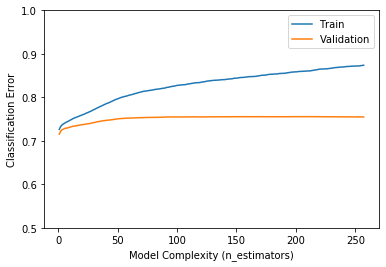

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt

results = model.evals_result()
train_error = results['validation_0']['auc']
val_error = results['validation_1']['auc']
epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.ylim((.5,1)) # Zoom in
plt.legend();